In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import re
import json
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from functools import lru_cache

In [3]:

# Electricity production capacities for renewables and wastes                    
NRG_IND_REN = 'data/nrg_ind_ren_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_ind_ren/default/table?lang=en 
# Share of energy from renewable sources 
NRG_INF_EPCRW = 'data/nrg_inf_epcrw_spreadsheet.xlsx'           # https://ec.europa.eu/eurostat/databrowser/view/nrg_inf_epcrw__custom_13973000/default/table?lang=en
# Simplified energy balances           
NRG_BAL_S = 'data/nrg_bal_s__custom_13973102_spreadsheet.xlsx'  # https://ec.europa.eu/eurostat/databrowser/view/nrg_bal_s__custom_13973102/default/table?lang=en
# Supply and transformation of solid fossil fuels
NRG_CB_SFFM = 'data/nrg_cb_sffm_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_sffm/default/table?lang=en 
# Electricity prices for household consumers          
NRG_PC_204 = 'data/nrg_pc_204_spreadsheet.xlsx'                 # https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_204/default/table?lang=en

# Population by educational attainment level, sex and age
EDAT_LFSE_03 = 'data/edat_lfse_03_spreadsheet.xlsx'             # https://ec.europa.eu/eurostat/databrowser/view/edat_lfse_03/default/table?lang=en
# Gross domestic product at market prices
TEC00001 = 'data/tec00001_page_spreadsheet.xlsx'                # https://ec.europa.eu/eurostat/databrowser/view/tec00001/default/table?lang=en

In [4]:
@lru_cache
def eurostat_dataset(path: str) -> pd.DataFrame:

    # retrieve sheets data and metadata from Summary sheet
    ## the time frequency and unit of measurement information 
    # is not a relevant index value since they are always the same
    ignore = ['Time frequency', 'Unit of measure']
    summary = pd.read_excel(
        path, sheet_name='Summary', 
        usecols=lambda col: \
            not col.startswith('Unnamed') and col not in ignore,
        index_col='Contents', skiprows=14
    )

    all = []

    # iterate over data sheets and pre-process them
    for sheet_name, config in summary.iterrows():

        # the valuable information starts with the row containing "TIME" indicating the start of the data table
        preview = pd.read_excel(path, sheet_name=sheet_name, usecols=[0])
        header_row = preview[preview.iloc[:, 0] == 'TIME'].index[0]

        data = pd.read_excel(
            path, sheet_name=sheet_name,
            usecols= lambda col: not str(col).startswith('Unnamed'),
            na_values=':', skiprows=header_row + 1
        )

        # Remove the first row "Geo (Label)"
        data = data.iloc[1:].reset_index(drop=True)

        # some sheets contain additional meta-data at the end which are seperated by a NaN value row from the actual data
        ## if we find such a row we remove all rows after
        first_blank_row_index = data.isnull().all(axis=1).idxmax() if data.isnull().all(axis=1).any() else None
        if first_blank_row_index is not None:
            data = data.loc[:first_blank_row_index - 1]

        # rename TIME to country
        data.rename(columns={'TIME': 'Country'}, inplace=True)

        # create multi-index based on config
        config_df = pd.DataFrame([config] * len(data), index=data.index)
        data = pd.concat([config_df, data], axis=1)
        data.set_index(['Country'] + list(config_df.columns), inplace=True)

        all.append(data)

    # merge them into one multi-index data frame 
    all = pd.concat(all).sort_index()
    
    return all

In [69]:
EU_COUNTRIES = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France",
    "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands",
    "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
]

print(len(EU_COUNTRIES))

27


In [71]:
# USER_AGENT = "MyWikiScraper/1.0 (josef.taha@tuwien.ac.at)"
# wiki = wikipediaapi.Wikipedia(user_agent=USER_AGENT, language="en")

# OVERVIEW = { country: wiki.page(country) for country in EU_COUNTRIES }
# ENERGY = { country: wiki.page("Renewable energy in " + country) for country in EU_COUNTRIES }
# EDUCATION = { country: wiki.page("Education in " + country) for country in EU_COUNTRIES }
# GEOGRPAHY = { country: wiki.page("Geography of " + country) for country in EU_COUNTRIES }
# POLITICS = { country: wiki.page("Politics of " + country) for country in EU_COUNTRIES }

# for country, page in ENERGY.items():
#     if not page.exists():
#         print(country)

# ENERGY['Luxembourg'].title

Creating  scores/ levels for renewable energy per country, as below.

In [128]:
energy_usage = eurostat_dataset(NRG_IND_REN)

# filter out non-EU countries
energy_usage = energy_usage.loc[energy_usage.index.get_level_values(0).isin(EU_COUNTRIES)]


# normalize % values of renewable energy shares
tmp = energy_usage.copy() / 100
growth = tmp.apply(lambda row: (row.iloc[-1] - row.iloc[0]) / len(row), axis=1) # avg growth per year
latest = tmp.iloc[:, -1] # latest shares
volatility = tmp.diff(axis=1).std(axis=1)

performance = pd.DataFrame({"latest": latest, "growth": growth, "volatility": volatility})

# normalize per each "energy balance" to calculate overall performance score
def normalize_per_sector(group):
    scaler = MinMaxScaler()
    return pd.DataFrame(scaler.fit_transform(group), index=group.index, columns=group.columns)

performance = performance.groupby(level=1, group_keys=False).apply(normalize_per_sector)

performance["score"] = (
    0.5 * performance["latest"] + 
    0.4 * performance["growth"] +
    0.1 * performance["volatility"] * (performance["growth"] > 0.05).astype(float)
)

performance["level"] = pd.qcut(performance["score"], 10, labels=range(1, 11), duplicates="drop").astype(float)
performance

latest    growth  \
Country Energy balance                                                        
Austria Renewable energy sources                         0.533556  0.536384   
        Renewable energy sources in electricity          1.000000  0.376023   
        Renewable energy sources in heating and cooling  0.532463  0.343378   
        Renewable energy sources in transport            0.375481  0.336058   
Belgium Renewable energy sources                         0.056998  0.321500   
...                                                           ...       ...   
Spain   Renewable energy sources in transport            0.337377  0.416021   
Sweden  Renewable energy sources                         1.000000  0.916735   
        Renewable energy sources in electricity          0.997183  0.592060   
        Renewable energy sources in heating and cooling  1.000000  0.389626   
        Renewable energy sources in transport            1.000000  1.000000   

                                                         volatility     score  \
Country Energy balance                                                          
Austria Renewable energy sources                           0.594255  0.540757   
        Renewable energy sources in electricity            1.000000  0.750409   
        Renewable energy sources in heating and cooling    0.653015  0.468884   
        Renewable energy sources in transport              0.062017  0.328366   
Belgium Renewable energy sources                           0.063250  0.163424   
...                                                             ...       ...   
Spain   Renewable energy sources in transport              0.162041  0.351301   
Sweden  Renewable energy sources                           0.346313  0.901325   
        Renewable energy sources in electricity            0.652753  0.800691   
        Renewable energy sources in heating and cooling    0.467275  0.702578   
        Renewable energy sources in transport              0.216047  0.921605   

                                                         level  
Country Energy balance                                          
Austria Renewable energy sources                           8.0  
        Renewable energy sources in electricity           10.0  
        Renewable energy sources in heating and cooling    8.0  
        Renewable energy sources in transport              6.0  
Belgium Renewable energy sources                           2.0  
...                                                        ...  
Spain   Renewable energy sources in transport              7.0  
Sweden  Renewable energy sources                          10.0  
        Renewable energy sources in electricity           10.0  
        Renewable energy sources in heating and cooling   10.0  
        Renewable energy sources in transport             10.0  

[108 rows x 5 columns]

Luxemburg got the worst ranking EU wide, which seemed to be reasonable due to its high usage of coal and fossil fuel for electricity and import of electricity from outside according to Wikipedia. Funfact: Czechia, Ireland and Louxemburg are the only countries that have no "renewable energy entry"  wikipedia page.

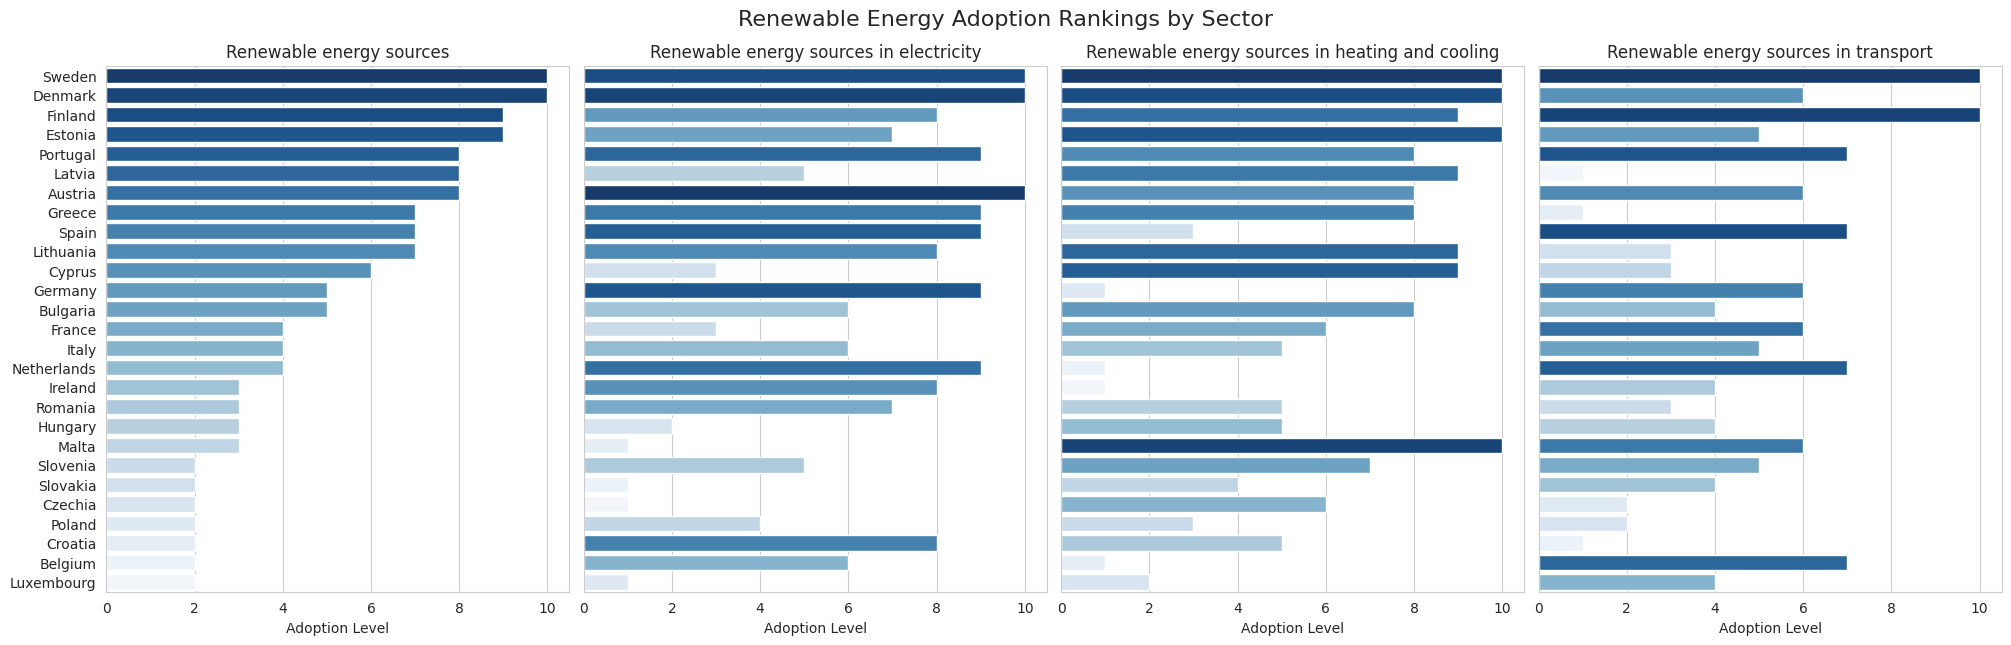

In [129]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True, constrained_layout=True)
levels = performance['level'].unstack(level=1)

for idx, sector in enumerate(levels.columns):
    sector_ranking = levels[sector].sort_values(ascending=False)
    sns.barplot(
        x=sector_ranking.values, 
        y=sector_ranking.index, 
        palette="Blues_r",
        hue=sector_ranking.index,
        ax=axes[idx]
    )

    axes[idx].set_title(sector, fontsize=12)
    axes[idx].set_xlabel("Adoption Level")
    axes[idx].set_ylabel("")

fig.suptitle("Renewable Energy Adoption Rankings by Sector", fontsize=16, y=1.05)
plt.show()

In [ ]:
levels = performance['level'].unstack(level=1)
sector_ranking = levels.reset_index().melt(id_vars="Country", var_name="Sector", value_name="Level")
sector_ranking = sector_ranking[sector_ranking["Level"] > 7]

fig = px.choropleth(
    sector_ranking,
    locations="Country",
    locationmode="country names",
    color="Sector",
    projection="natural earth",
    scope="europe",
    title="Countries with Renewable Energy Adoption Level > 7",
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

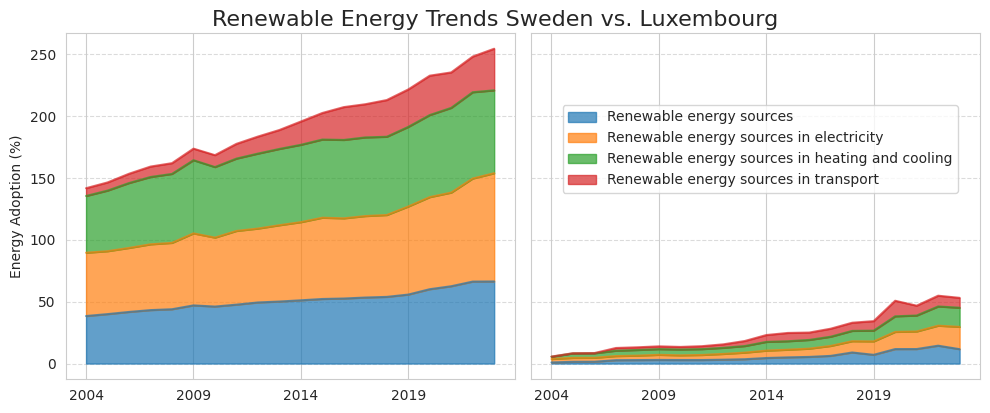

In [124]:
countries_to_compare = ("Sweden", "Luxembourg")
comparison_data = energy_usage.loc[energy_usage.index.get_level_values(0).isin(countries_to_compare)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(countries_to_compare):
    country_data = comparison_data.loc[country]
    
    country_data.T.plot(kind='area', stacked=True, alpha=0.7, ax=axes[idx], legend=False)
    
    axes[idx].set_ylabel("Energy Adoption (%)", fontsize=10)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.97, 0.8), fontsize=10)

plt.tight_layout()
plt.suptitle("Renewable Energy Trends Sweden vs. Luxembourg", fontsize=16, y=1.02)
plt.show()